#### Pakkar

In [1]:
# Our Libraries 
from ourModules import text_processor
from ourModules import toxic_comment_Classifier

/Users/numisteinn/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [293]:
# Libraries ---------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction import stop_words
import string
from tensorflow.python.keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras.optimizers import Adadelta
import scipy.sparse
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import warnings; 
# # %tensorflow_version 1.x
# import tensorflow
# print(tensorflow.__version__)
import tensorflow as tf

In [4]:
tf.compat.v1.disable_eager_execution()

#### Innlestur gagna

In [5]:
train_data = pd.read_csv('data/train.csv',delimiter=',')
train_data.drop('id',axis=1,inplace=True) # Id er gagnslaust til ad spa
# test_labeled_data = pd.read_csv('data/test_labels.csv',delimiter=',') # Will most likely not be used



### Gagnasettið
Hér má sjá gagnasettið sem við þjálfum módelið á. Við erum með comment_text og hann er búið að greina (0 eða 1) hvort hann sé toxic, severe_toxic, obscene, threat, insult eða identity_hate.

In [6]:
# Nota þetta til að testa loka módelið
cols = list(train_data)
X_train_data = train_data.drop(columns = cols[1:])
y_train_data = train_data.drop(columns = cols[:1])

# 80/20 train/test split
# Mögulega þarf að nota sklearn.cross_validation.StratifiedShuffleSplit frekar til að halda svipuðu 
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=12)
X_train_np, X_test_np, y_train_np, y_test_np = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()


Data subsampling succsessful!
Reducing dimensions...
Plotting PCA projection...


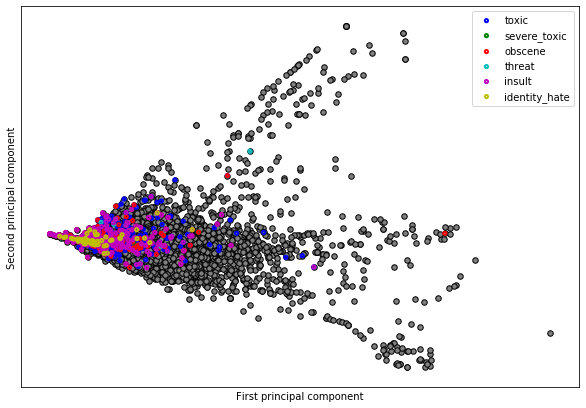

In [470]:
def plot_pca(x_data, y_data, colum_names):
    # P
    print("Reducing dimensions...")
    x_2d = PCA(n_components=2).fit_transform(x_data.todense())

    print("Plotting PCA projection...")
    min_x = np.min(x_2d[:, 0])
    max_x = np.max(x_2d[:, 0])

    min_y = np.min(x_2d[:, 1])
    max_y = np.max(x_2d[:, 1])

    colors_ = ['b', 'g', 'r', 'c', 'm', 'y']
    plt.figure(figsize=(10, 7))
    #plots all the dots
    plt.scatter(x_2d[:, 0], x_2d[:, 1], s=30, c='gray', edgecolors=(0, 0, 0))
    for i in range(len(colum_names)):
        label_ = np.where(y_data[:, i])
        plt.scatter(x_2d[label_, 0], x_2d[label_, 1], s=10, edgecolors=colors_[i],
                facecolors='none', linewidths=2, label=colum_names[i])
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)

    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend(loc="upper right")
    plt.autoscale()
    plt.show()
    
# Dimensionality reduction
train_size = 10000

#tekur um sec þús train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)
plot_pca(X_train_reduced, y_train_reduced, cols[1:])


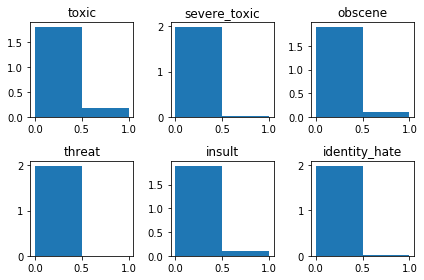

Number of instances marked with toxic: 	 12143/127656 or 9.51%
Number of instances marked with severe_toxic: 	 1265/127656 or 0.99%
Number of instances marked with obscene: 	 6714/127656 or 5.26%
Number of instances marked with threat: 	 387/127656 or 0.30%
Number of instances marked with insult: 	 6275/127656 or 4.92%
Number of instances marked with identity_hate: 	 1117/127656 or 0.88%


In [7]:
# Visualize distribution of y
n_bins = 2
fig, axes = plt.subplots(nrows=2, ncols=3)
axs = axes.flatten()
i = 0
for col in cols[1:]:
    axs[i].hist(y_train[col], n_bins, density=True, histtype='bar')
    axs[i].set_title(col)
    i +=1
fig.tight_layout()
plt.show()
# Notice skewed dataset
for col in cols[1:]:
    cnt = np.count_nonzero(y_train[col])
    print('Number of instances marked with {}: \t {}/{} or {:.2%}'.format(col, cnt,
                                                                    y_train_np.shape[0], cnt/y_train_np.shape[0]) )

In [234]:
def get_row_accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred, axis = 1)
    return np.average(np.where(acc == 6, 1, 0), axis = 0)

n,m = y_train_np.shape
y_pred = np.zeros(n)

rowindx, colindx = np.nonzero(y_train_np)
rwi = np.unique(rowindx)
# print('Number of rows with at least one none-zero value ', len(rwi))
# non_zero_y_train = y_train_np[rwi]
# # for i in range(m):
# #     print('All-zero guess accuracy on data for {} is: {:.2%}'.format(cols[i+1], np.average(y_pred == y_train_np[:, i])))
# #     print('All-zero guess accuracy for {} but all-zero-rows removed is: {:.2%}'.format(cols[i+1],
# #                                                                 np.average(y_pred[rwi] == non_zero_y_train[:, i])))
# #     print('-'*100)

print('All-zero guess row accuracy on data is: {:.2%}'.format(get_row_accuracy(y_train_np, y_pred_mat)))

All-zero guess row accuracy on data is: 89.89%


### State Vector Machine / Baseline Model




Lets build our first model. We start by making a simple SVM, which is widely regarded as one of the best text classification algorithms. This baseline classifier which treats the labels independently by training a binary classifier on each label separately. This initial model does not implement multilable classifaction in the best way nor does it take into account the skewed data.

In [92]:

# subsamples the data but makes sure all y columns include 2 classes
def data_subsample_asserts_two_classes(X, y, n):
    # Select a random subset of the training data
    max_tries = 15
    tries = 0
    while tries < max_tries:
        perm = np.random.permutation(len(y))
        X_sub=X[perm[0:n],:]
        y_sub=y[perm[0:n]]
        count = 0
        length = y_sub.shape[1]
        for i in range(length):
            # Make sure all columns have 2 classes
            if len(np.unique(y_sub[:,i])) < 2:
                break
            if i == (length-1):
                print('Data subsampling succsessful!')
                return X_sub, y_sub
        tries += 1
#         print("Data subsampling failed in {} try. Trying again.".format(tries) )
#         print('-'*100)
    print("Data subsampling failed in {} tries".format(max_tries))
    return 0,0


In [387]:

def plot_acc_params(param, train_acc_, val_acc_, param_name, title):
    plt.plot(param, train_acc_,label='Training accuracy')
    plt.plot(param, val_acc_,label='Validation accuracy')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def find_best_SVM_params(Cs, gammas, kernel_, xtrain, ytrain, xval, yval):
    training_acc = np.zeros(len(Cs))
    val_acc = np.zeros(len(Cs))
    # ignores the gamma values if linear
    if kernel_ != 'linear':
        training_acc = np.zeros((len(Cs), len(gammas)))
        val_acc = np.zeros((len(Cs), len(gammas)))
    
    for i in range(len(Cs)):
        print("c: ", Cs[i])
        if kernel_ != 'linear':
            for j in range(len(gammas)):
                print("gamma: ", gammas[j], end =" ")
                clf = OneVsRestClassifier(SVC(gamma=gammas[j], C = Cs[i], kernel = kernel_))
                clf.fit(xtrain, ytrain)
                val_acc[i, j] = get_row_accuracy(yval, clf.predict(xval))
                training_acc[i, j] = get_row_accuracy(ytrain, clf.predict(xtrain))
            print()
        else:
            clf = OneVsRestClassifier(SVC(C = Cs[i], kernel = kernel_))
            clf.fit(xtrain, ytrain)
            val_acc[i] = get_row_accuracy(yval, clf.predict(xval))
            training_acc[i] = get_row_accuracy(ytrain, clf.predict(xtrain))
#     print('Train acc \n', training_acc)
#     print('Validation acc \n', val_acc)
    return training_acc, val_acc

# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_heatmap(data_matrix, title, xlabel, ylabel, x_values, y_values, vmin_, midpoint_):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(data_matrix, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=vmin_, midpoint=midpoint_))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    
    
    plt.xticks(np.arange(len(x_values)), x_values, rotation=45)
    plt.yticks(np.arange(len(y_values)), y_values)
    plt.title(title)
    plt.show()


In [245]:
%%time
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, 5000)
print("Number of training instances: ", X_train_reduced.shape[0])

# Bag of words approach
# CountVectorizer has the benefit of producing a sparse representation of the counts 
vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features = None, stop_words='english')
tfidf_transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(X_train_reduced.ravel())
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# Rough search for a good estimate of C and gamma
x_test_unrvld = vectorizer.transform(X_test_np.ravel())

C = 0.01* np.power(10,np.arange(5))
gamma = 1/np.power(10,np.arange(4))

accs = { 'val_acc': {'rbf': np.zeros((len(C), len(gamma))),
                     'linear': np.zeros(len(C)) },
        'train_acc': {'rbf': np.zeros((len(C), len(gamma))),
                     'linear': np.zeros(len(C)) } 
       }
kernels = ['rbf', 'linear']
for kernel in kernels:
    print('-'*100)
    print('Using kernel ', kernel)
    print('Testing parameters, C: {},\ngamma: {}'.format(C, gamma))
    tA, vA = find_best_SVM_params(C, gamma, kernel,
                                     X_train_tfidf, y_train_reduced,
                                     x_test_unrvld, y_test_np)
    accs['train_acc'][kernel] = tA
    accs['val_acc'][kernel] = vA

rbfacc = accs['val_acc']['rbf']; linacc = accs['val_acc']['linear']
Cind, gammaind = np.unravel_index(np.argmax(rbfacc, axis=None), rbfacc.shape)
print('For rbf kernal')
rbfOptparam = C[Cind], gamma[gammaind]
print("Optimal combination is,  C: {}, gamma: {}".format(rbfOptparam[0], rbfOptparam[1]))
print("Giving the validation accuracy: {:.2%}".format(rbfacc[Cind, gammaind]))

Cindex = np.argmax(linacc)
linearOptC = C[Cindex]
print('For linear kernal')
print("Optimal C is: {}".format(linearOptC))
print("Giving the validation accuracy: {:.2%}".format(linacc[Cindex]))

Data subsampling succsessful!
Number of training instances:  5000
----------------------------------------------------------------------------------------------------
Using kernel  rbf
Testing parameters, C: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02],
gamma: [1.    0.1   0.01  0.001]
c:  0.01
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  0.1
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  1.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  10.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
c:  100.0
gamma:  1.0 gamma:  0.1 gamma:  0.01 gamma:  0.001 
----------------------------------------------------------------------------------------------------
Using kernel  linear
Testing parameters, C: [1.e-02 1.e-01 1.e+00 1.e+01 1.e+02],
gamma: [1.    0.1   0.01  0.001]
c:  0.01
c:  0.1
c:  1.0
c:  10.0
c:  100.0
For rbf kernal
Optimal combination is,  C: 10.0, gamma: 0.01
Giving the validation accuracy: 90.94%
For linear kernal
Optimal C is: 0.1
Giving the validation

For rbf kernal
Optimal combination is,  C: 10.0, gamma: 0.01
Giving the validation accuracy: 90.94%
For linear kernal
Optimal C is: 0.1
Giving the validation accuracy: 90.61%


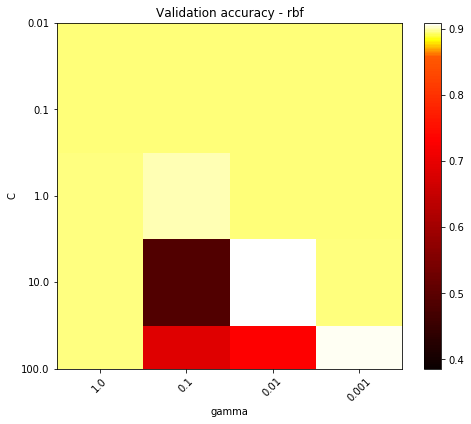

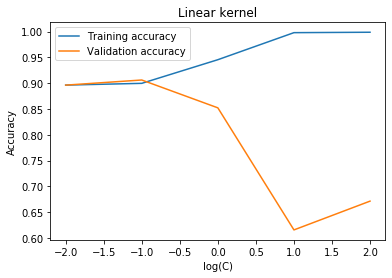

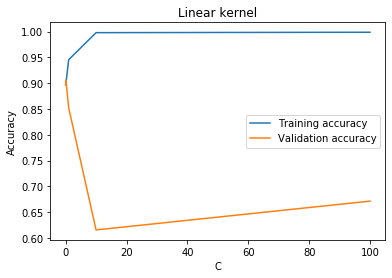

In [247]:
rbfacc = accs['val_acc']['rbf']; linacc = accs['val_acc']['linear']
Cind, gammaind = np.unravel_index(np.argmax(rbfacc, axis=None), rbfacc.shape)
print('For rbf kernal')
rbfOptparam = C[Cind], gamma[gammaind]
print("Optimal combination is,  C: {}, gamma: {}".format(rbfOptparam[0], rbfOptparam[1]))
print("Giving the validation accuracy: {:.2%}".format(rbfacc[Cind, gammaind]))

linearOptC = C[np.argmax(linacc)]
print('For linear kernal')
print("Optimal C is: {}".format(linearOptC))
print("Giving the validation accuracy: {:.2%}".format(linacc[Cindex]))

plot_heatmap(rbfacc, 'Validation accuracy - rbf', 'gamma', 'C', gamma, C,
             np.min(rbfacc) - 0.1, np.max(rbfacc)-0.05)
plot_acc_params(np.log10(C), accs['train_acc']['linear'], accs['val_acc']['linear'], 'log(C)', 'Linear kernel')
plot_acc_params(C, accs['train_acc']['linear'], accs['val_acc']['linear'], 'C', 'Linear kernel')


In [259]:
%%time
def vectorize_data(X_train_):
    vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features = None, stop_words='english')
    tfidf_transformer = TfidfTransformer()
    X_train_counts = vectorizer.fit_transform(X_train_.ravel())
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    return X_train_tfidf, vectorizer

# Tekur ca 8min að keyra á 50þus train size
train_size = 50000
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

x_test_unrvld = vectorizer.transform(X_test_np.ravel())
clf = OneVsRestClassifier(SVC(C = linearOptC, kernel = 'linear'))
clf.fit(X_train_reduced, y_train_reduced)
test_acc = get_row_accuracy(y_test_np, clf.predict(vectorizer.transform(X_test_np.ravel())))
print('Training size', train_size)
print('Using optimal C: {}'.format(linearOptC))
print('Test accuracy on linear kernel {:.2%}'.format(test_acc))

Data subsampling succsessful!
Training size 50000
Using optimal C: 0.1
Test accuracy on linear kernel 91.12%
CPU times: user 8min 13s, sys: 1.82 s, total: 8min 15s
Wall time: 8min 8s


In [261]:
%%time
# Tekur ca 8min að keyra á 50þus train size
print('Training size', train_size)
print('Using optimal C: {} and gamma: {}'.format(rbfOptparam[0], rbfOptparam[1]))

x_test_unrvld = vectorizer.transform(X_test_np.ravel())
clf = OneVsRestClassifier(SVC(C = rbfOptparam[0], gamma = rbfOptparam[1], kernel = 'rbf'))
clf.fit(X_train_reduced, y_train_reduced)

y_pred = clf.predict(vectorizer.transform(X_test_np.ravel()))
test_acc = get_row_accuracy(y_test_np, y_pred)

print('Test accuracy on rbf kernel {:.2%}'.format(test_acc))

Training size 50000
Using optimal C: 10.0 and gamma: 0.01
Test accuracy on rbf kernel 85.19%
CPU times: user 7min 43s, sys: 1.6 s, total: 7min 44s
Wall time: 7min 41s


### Random forrest


Data subsampling succsessful!
depth range: range(50, 350, 50)
features_range [60, 110, 160, 210, 260, 310, 360, 410, 'sqrt']
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  5.1min finished


Optimal parameters for the grid are {'max_depth': 150, 'max_features': 410}s with a score of 91.76%


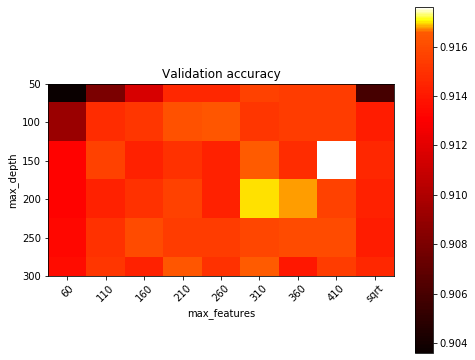

CPU times: user 8.67 s, sys: 168 ms, total: 8.84 s
Wall time: 5min 14s


In [400]:
%%time
warnings.filterwarnings("ignore") # ignore warnings for the purpose of readability

train_size = 5000
# tekur um 1min+ med 5 þúsund train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)
depth_range = range(50, 350, 50)
features_range = np.arange(60, 420, 50).tolist()
features_range.append('sqrt')
print('depth range:', depth_range)
print('features_range', features_range)

parameters = {
    'max_depth': depth_range,
    'max_features': features_range
}
rf = RandomForestClassifier(n_estimators=100, oob_score=False)
grid = GridSearchCV(rf, parameters, verbose=2, n_jobs=-1) #n_jobs=-1 notar alla kjarna
grid.fit(X_train_reduced, y_train_reduced)
print("Optimal parameters for the grid are {}s with a score of {:.2%}".format(grid.best_params_, grid.best_score_))
# Use our best RF model 
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=grid.best_params_['max_depth'],
    max_features=grid.best_params_['max_features'],
    oob_score=False
)

scores = grid.cv_results_['mean_test_score'].reshape(len(depth_range),len(features_range))
plot_heatmap(scores, 'Validation accuracy', 'max_features', 'max_depth', 
              features_range, depth_range, np.min(scores), np.max(scores)-0.001)

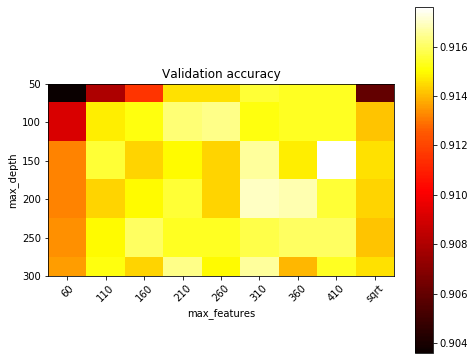

In [406]:
# print(grid.cv_results_)
# print(grid.cv_results_['mean_test_score'])

scores = grid.cv_results_['mean_test_score'].reshape(len(depth_range),len(features_range))
plot_heatmap(scores, 'Validation accuracy', 'max_features', 'max_depth', 
              features_range, depth_range, np.min(scores), np.max(scores)-0.005)

In [408]:
%%time
train_size = 50000
#tekur um 1min20 sec með 50þús train size
X_train_reduced, y_train_reduced = data_subsample_asserts_two_classes(X_train_np, y_train_np, train_size)
X_train_reduced, vectorizer = vectorize_data(X_train_reduced)

# Fit and test it
max_depth=grid.best_params_['max_depth']
max_features=grid.best_params_['max_features']
print('Training size: ', train_size)
print('Using max depth: {} and max features: {}'.format(max_depth, max_features))
rf.fit(X_train_reduced, y_train_reduced)
y_test_pred = rf.predict(vectorizer.transform(X_test_np.ravel()))
test_acc = get_row_accuracy(y_test_np, y_test_pred)
print('Test acc {:.2%}'.format(test_acc))

Data subsampling succsessful!
Training size:  50000
Using max depth: 150 and max features: 410
Test acc 89.52%
CPU times: user 2min 1s, sys: 699 ms, total: 2min 2s
Wall time: 1min 12s


Data subsampling succsessful!
Reducing dimensions...
Plotting PCA projection...


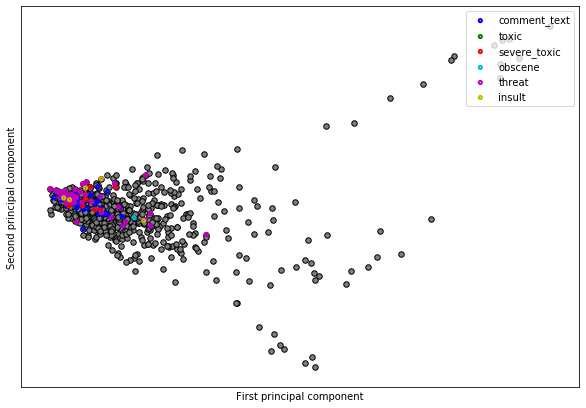

CPU times: user 1.21 s, sys: 138 ms, total: 1.35 s
Wall time: 329 ms


### Text preprocessing


Hér er þá búið að preprocessa textann

In [9]:
def getProcessedText(dataset):
    x_train = dataset['comment_text'].to_numpy()
    for i in range(len(x_train)):
        x_train[i] = textpreprocess(x_train[i])
    return x_train

In [10]:
x_train = train_data['comment_text'].to_numpy()
for i in range(len(x_train)):
    x_train[i] = text_processor.textPreprocess(x_train[i])

In [11]:
max_comment_length = len(train_data['comment_text'][0])

for comment in train_data['comment_text']:
    if len(comment) > maxlen:
        max_comment_length = len(comment)
print(maxlen)

NameError: name 'maxlen' is not defined

Prófa að exclude-a bara toxic dálkinn og gera model á honum

In [ ]:
toxicCol = train_data['toxic']
classes = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

In [ ]:
# X_train = train_data['comment_text'].to_numpy()
X_train = x_train
# y_train = (train_data.values[:,2:])
y_train = toxicCol
print(len(toxicCol), len(X_train))
# Set aside validation data for monitoring training progress

assert len(X_train) == len(y_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print('=================')
print('|','train_data shape:', X_train.shape)
print('|',X_train.shape[0], 'train samples')
print('|',y_test.shape[0], 'test samples')
print('=================')

In [ ]:
max_words = 20000 # <- spurning um hvað þetta eigi að vera

tokenizer = text.Tokenizer(num_words=max_words)
num_classes = 6

tokenizer.fit_on_texts(list(X_train))
tokTrain = tokenizer.texts_to_sequences(X_train)
tokTest = tokenizer.texts_to_sequences(X_test)

x_train=sequence.pad_sequences(tokTrain, maxlen=max_comment_length)
x_test=sequence.pad_sequences(tokTest, maxlen=max_comment_length)


In [ ]:
model = Sequential()
model.add(Dense(512,input_shape=(max_comment_length,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(optimizer=Adadelta(),
          loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 2
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose = 1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test acc: {}'.format(score[1]))